In [128]:
import numpy as np
import scipy.stats as sts
import scipy.special as spec
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integral
import pandas as pd
import statsmodels.api as sm
import numpy.linalg as lin
%matplotlib notebook

In [129]:
#input data
dt = pd.read_excel('data.xlsx')
T = 1000
S = 100
sigma_y = 0.351
sigma_pi= 0.963
sigma_i = 0.331
alpha_pi = 0.356
gamma = 0

In [130]:
#Generate three shocks
unif_vals_1 = sts.uniform.rvs(0, 1, size=(T, S))
unif_vals_2 = sts.uniform.rvs(0, 1, size=(T, S))
unif_vals_3 = sts.uniform.rvs(0, 1, size=(T, S))

In [131]:
#Generate a Matrix from uniform distribution.
def norm_draws(unif_vals, sigma):
    norm_draws = sts.norm.ppf(unif_vals, loc=0, scale=sigma)
    
    return norm_draws

In [132]:
#defined model function to simulate model data
def model(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y):
    
    interest_rate_lag = 3.99*np.ones(S)
    b = np.zeros((T, S))
    pi_c = np.zeros((T, S))
    interest_rate = np.zeros((T, S))
    pi = np.zeros((T, S))
    y = np.zeros((T, S))
    
    probnp = np.zeros(S)
    probpn = np.zeros(S)
    
    b[0,:] = 0.3*np.ones(S)
    pi_c[0,:] = 2.23*np.ones(S)
    
    Shock_y = norm_draws(unif_vals_1, sigma_y)
    Shock_pi = norm_draws(unif_vals_2, sigma_pi)
    Shock_i = norm_draws(unif_vals_3, sigma_i)
    
    for i in range(T):
        y[i,:] = eta * b[i,:] + Shock_y[i,:]
        pi[i,:] = pi_c[i,:] + kappa * y[i,:] + Shock_pi[i,:]
        interest_rate[i,:] = mu_i * interest_rate_lag + (1-mu_i) * (5 + mu_pi * (pi[i,:] - 2.5) + mu_y * y[i,:])\
                             + Shock_i[i,:]
        
        if i < T-1:
            pi_c[i+1,:] = pi_c[i,:] + alpha_pi * (gamma*2.5 + (1-gamma) * pi[i,:] - pi_c[i,:])
            
            f = sai_b*b[i,:] - sai_i*(interest_rate[i,:] - pi[i,:] - 2.5)
            for j in range(S):
                probnp[j] = min(1, 0.125*np.exp(f[j]))
                probpn[j] = min(1, 0.125*np.exp(-f[j]))
            
            b[i+1,:] = b[i,:] + np.multiply((1-b[i,:]), probnp) - np.multiply((1+b[i,:]), probpn)
            
        interest_rate_lag = interest_rate[i,:]
        
    return y[200:,:], pi[200:,:], interest_rate[200:,:]
    #return y, pi, interest_rate

In [133]:
# Compute model moment
def model_mom(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y):
    y_mod, pi_mod, i_mod = model(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y)
    
    y_mean = np.zeros(S)
    y_std = np.zeros(S)
    pi_mean = np.zeros(S)
    pi_std = np.zeros(S)
    i_mean = np.zeros(S)
    i_std = np.zeros(S)
    
    yi_cov = np.zeros(S)
    ypi_cov = np.zeros(S)
    ipi_cov = np.zeros(S)
    yylag_cov = np.zeros(S)
    pplag_cov = np.zeros(S)
    iilag_cov = np.zeros(S)
    
    for i in range(S):
        y_mean[i] = y_mod[:,i].mean()
        y_std[i] = y_mod[:,i].std()
        pi_mean[i] = pi_mod[:,i].mean()
        pi_std[i] = pi_mod[:,i].std()
        i_mean[i] = i_mod[:,i].mean()
        i_std[i] = i_mod[:,i].std()
        
        yi_cov[i] = np.cov(y_mod[:,i], i_mod[:,i])[0][1]
        ypi_cov[i] = np.cov(y_mod[:,i], pi_mod[:,i])[0][1]
        ipi_cov[i] = np.cov(i_mod[:,i], pi_mod[:,i])[0][1]
        
        yylag_cov = np.cov(y_mod[1:T-200,i], y_mod[:T-200-1,i])[0][1]
        iilag_cov = np.cov(i_mod[1:T-200,i], i_mod[:T-200-1,i])[0][1]
        pplag_cov = np.cov(pi_mod[1:T-200,i], pi_mod[:T-200-1,i])[0][1]
        
    y_m = y_mean.mean()
    y_s = y_std.mean()
    pi_m = pi_mean.mean()
    pi_s = pi_std.mean()
    i_m = i_mean.mean()
    i_s = i_std.mean()
    yi_cov_m = yi_cov.mean()
    ypi_cov_m = ypi_cov.mean()
    ipi_cov_m = ipi_cov.mean()
    
    yylag_cov_m = yylag_cov.mean()
    iilag_cov_m = iilag_cov.mean()
    pplag_cov_m = pplag_cov.mean()
    
    return np.array([y_m, y_s, pi_m, pi_s, i_m, i_s, yi_cov_m, ypi_cov_m, ipi_cov_m, yylag_cov_m, iilag_cov_m,\
                     pplag_cov_m])

In [134]:
#compute data moment
dt_y = dt['Output Gap'].values
dt_p = dt.Inflation.values
dt_i = dt['interest rate'].values

y_dat_mean = dt_y.mean()
y_dat_std = dt_y.std()

pi_dat_mean = dt_p.mean()
pi_dat_std = dt_p.std()

i_dat_mean = dt_i.mean()
i_dat_std = dt_i.std()

yi_dat_cov = np.cov(dt_y, dt_i)
ypi_dat_cov = np.cov(dt_y, dt_p)
ipi_dat_cov = np.cov(dt_i, dt_p)

yylag_dat_cov = np.cov(dt_y[1:78], dt_y[:78-1])
iilag_dat_cov = np.cov(dt_i[1:78], dt_i[:78-1])
pplag_dat_cov = np.cov(dt_p[1:78], dt_p[:78-1])

data_mom = np.array([y_dat_mean, y_dat_std, pi_dat_mean, pi_dat_std, i_dat_mean, i_dat_std, yi_dat_cov[0][1],\
           ypi_dat_cov[0][1], ipi_dat_cov[0][1], yylag_dat_cov[0][1], iilag_dat_cov[0][1], pplag_dat_cov[0][1]])


In [135]:
#Compute the error vector
def err_vec(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y):
    m_mom = model_mom(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y)
    err = m_mom - data_mom
    
    return err

In [136]:
#Compute criterion function
def crit(params, *args):
    sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y = params
    W_hat = args
    
    err = err_vec(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y)
    
    crit_val = np.dot(np.dot(err.T, W_hat), err)
    
    return crit_val

In [137]:
# Since we want to use the Iterated variance covariance estimator, then we first estimate the
# parameters by using the Identity Matrix
W_Id = np.eye(12)
sai_b_init = 0.563
sai_i_init = 0.726
eta_init = 3.85
kappa_init =  0.454
mu_i_init = 0.394
mu_pi_init = 1.578
mu_y_init = 0

params_init = np.array([sai_b_init, sai_i_init, eta_init, kappa_init, mu_i_init, mu_pi_init, mu_y_init])
W_hat = W_Id

results = opt.minimize(crit, params_init, args=(W_hat), method='L-BFGS-B',bounds=((0, 5), (1e-2, 15),(1e-2,None),\
                                                                                  (1e-2,1),(0,1),\
                                                                                  (1e-2,4),(0,5)))

In [138]:
results

      fun: array([ 20.75975157])
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.98783220e-04,  -5.63105118e-04,  -1.14042109e-04,
         1.98419059e-03,   4.13961807e+00,  -9.75326486e-03,
        -2.33804087e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1144
      nit: 106
   status: 0
  success: True
        x: array([ 2.82940066,  1.54017652,  4.74669562,  0.10933049,  0.        ,
        1.02898316,  0.25754154])

In [143]:
Shock_y = norm_draws(unif_vals_1, sigma_y)
Shock_pi = norm_draws(unif_vals_2, sigma_pi)
Shock_i = norm_draws(unif_vals_3, sigma_i)

avg_shock_y = np.zeros(T)
avg_shock_pi = np.zeros(T)
avg_shock_i = np.zeros(T)


for i in range(T):
    avg_shock_y[i] = Shock_y[i,:].mean()
    avg_shock_pi[i] = Shock_pi[i,:].mean()
    avg_shock_i[i] = Shock_i[i,:].mean()

In [147]:
# After getting the average shock, we compute the model data

R = 1000
def mod(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y):
    interest_rate_lag = 3.99
    b = np.zeros(R)
    pi_c = np.zeros(R)
    pi_c[0] = 2.23
    b[0] = 0.3
    
    
    interest_rate = np.zeros(R)
    pi = np.zeros(R)
    y = np.zeros(R)
    f = np.zeros(R-1)
    
    
    for i in range(R):
        y[i] = eta*b[i] + avg_shock_y[i]
        pi[i] = pi_c[i] + kappa*y[i] + avg_shock_pi[i]
        interest_rate[i] = mu_i * interest_rate_lag + (1-mu_i) * (5 + mu_pi * (pi[i] - 2.5) + mu_y * y[i]) + avg_shock_i[i]
        
        if i < S-1:
            pi_c[i+1] = pi_c[i] + alpha_pi * (gamma*2.5 + (1-gamma) * pi[i] - pi_c[i])
            
            f[i] = sai_b*b[i] - sai_i*(interest_rate[i] - pi[i] - 2.5)
            probnp = min(1,0.125*np.exp(f[i]))
            probpn = min(1,0.125*np.exp(-f[i]))
            b[i+1] = b[i] + (1-b[i])*probnp - (1+b[i])*probpn
        
        interest_rate_lag = interest_rate[i]
        
    return y[200:], pi[200:], interest_rate[200:], f

In [150]:
y,pi,i,f = mod(2.82940066,  1.54017652,  4.74669562,  0.10933049,  0.        ,
        1.02898316,  0.25754154)
x = list(range(100))

<IPython.core.display.Javascript object>


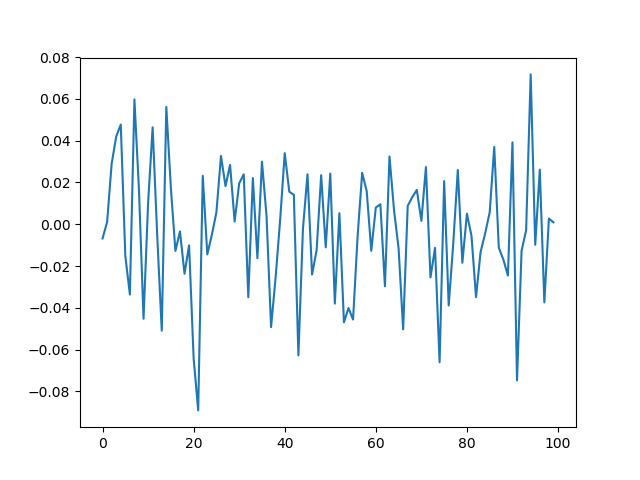

In [151]:
plt.plot(x,y[:100])
plt.show()